# Analyzing velocity and pumping with Pharaglow

## Importing packages

In [1]:
%matplotlib inline
import pandas as pd
import os
import numpy as np

# plotting
import matplotlib  as mpl
import matplotlib.pylab as plt

# image processing
import skimage
from skimage import io
from skimage.util import img_as_float
from skimage.filters import threshold_li
from scipy import ndimage
from skimage.morphology import remove_small_objects
from skimage.exposure import histogram
import json
import pims
import trackpy as tp

# our packages
from pharaglow import extract, util
from pharaglow.util import smooth

## Directing path options and variables (CHANGE NAMES OR YOUR FILES ARE OVERWRITTEN)

In [2]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
ctrl = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/"
INF100 = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_INF100/"

# IS THERE A LAWN?
lawn = 'Yes' #or 'No'
print('Is there a lawn?', lawn)

# FPS?
fps = 30
print('fps:', fps)

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

# FIGURE NAMES
# all_velocities = "/home/nzjacic/Desktop/Rough_figures/10X_INF100/10x_INF100.5_all_velocities.pdf"
# averaged_velocities = "/home/nzjacic/Desktop/Rough_figures/10x_INF100/10x_INF100.5_combined_averaged_velocities.pdf"
# entry_trajectory = "/home/nzjacic/Desktop/Rough_figures/10X_INF100/10x_INF100.5_entries_trajectories.pdf"

Is there a lawn? Yes
fps: 30


## Defining functions

### Defining function to prepare binary of lawn image

In [3]:
def prepLawn(filename):
    # outlining lawn and turning into binary - thresholding with li (CHANGE NAME)
    image = img_as_float(skimage.io.imread(filename)).astype(np.float64)
    thresh = threshold_li(image)
    binary = image > thresh
    # troubleshooting images with noise around the lawn (optional)
    binary = remove_small_objects(binary, min_size = 5000, connectivity = 2) #change min_size 
    # filling small holes in the lawn
    binary = ndimage.binary_fill_holes(binary).astype(int)
    return binary

### Defining functions to extract velocity, pumping and kymo (?)

In [4]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(traj):
    return extract.bestMatchPeaks(traj['pumps'])

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

### Defining how Python reads in Pharaglow and lawn data

In [24]:
%%time
def readData(dataFolder, umPerPx, fps, j = 0):
    df = {}
    lawnImages = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            p, pump, pks, roc  = getPumps(traj)
            kymo = getKymo(traj, 'Straightened')
            df[j] = {'time': t,
                     'x': traj['x'],
                     'y': traj['y'],
                             'velocity':v,
                             'peaks': p,
                             'pumpTrace':pump.values,
                             'inside': traj['inside'],
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo
                                 }
            j +=1
            # creating dictionary of lawn images based on exp.ID if necessary
#             if lawn == 'Yes':
#                 lawnfile = particle_index
#                 if lawnfile not in lawnImages.keys():
#                     lawnpath = '/media/scholz_la/hd2/Nicolina/Lawns/'
#                     lawnImages[lawnfile] = prepLawn(os.path.join(lawnpath, lawnfile+'_lawn.tiff') or os.path.join(lawnpath, lawnfile+'_lawn.bmp'))
#                     print(lawnfile)
    return df

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 22.2 µs


## Plotting

### Reading in Pharaglow results for different strains/conditions

In [25]:
%%time

# Making dictionary combining data with strain name in their separate master folders
Data = {}
for strainName, folder in zip(['Control', 'INF100'], [ctrl, INF100]):
    Data[strainName] = readData(folder, umPerPx, fps)

# # control
# ctrlData = ctrlData.update(readData(folder, umPerPx, fps, j = j))

# # strain 1 - INF100
# INF100Data ={}
# j = 0
# for folder in INF100:
#     INF100Data.update(readData(folder, umPerPx, fps, j = j))
#     j = max(INF100Data.keys())+1

Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_0.json


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  # Remove the CWD from sys.path while we load stuff.


Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_1.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_11.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_12.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_13.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_14.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_2.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_4.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_5.json
Reading /media/schol

### Extract velocity for all worms in all conditions

pid: INF100 0
f: 0.5883987109678853
t0: 1413
t0-dt or t0+dt exceeds number of frames
pid INF100 1
f out of bounds
pid: INF100 2
f: 0.6122868545168703
t0: 1446
t0-dt or t0+dt exceeds number of frames
pid: INF100 3
f: 0.26752633490737376
t0: 4033
t0-dt or t0+dt exceeds number of frames
pid: INF100 4
f: 0.1369435042957563
t0: 3218
t0-dt or t0+dt exceeds number of frames
pid INF100 5
f out of bounds
pid INF100 6
f out of bounds
pid: INF100 7
f: 0.012641815235008104
t0: 3046
t0-dt or t0+dt exceeds number of frames
pid: INF100 8
f: 0.6129032258064516
t0: 0
trajectory is too short


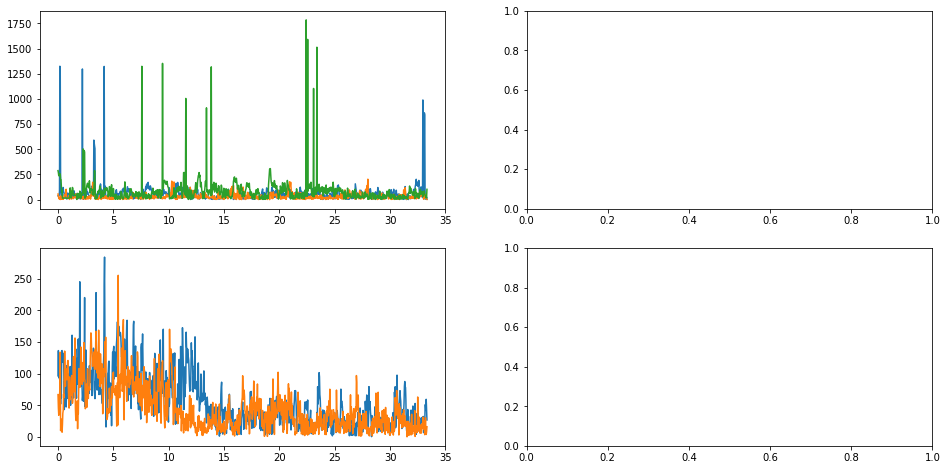

In [92]:
# graphing velocity using grid subplotting
f1 = plt.figure(figsize = (16,8))
dt = 500
# change number of rows to the number of strains
grid = mpl.gridspec.GridSpec(ncols=2, nrows =2)
# setting up subplots for velocity (a) and pumping (b) - add as number of strains increase
# velocity
ax1a = f1.add_subplot(grid[0,0])
ax2a = f1.add_subplot(grid[1,0])
# pumping
ax1b = f1.add_subplot(grid[0,1])
ax2b = f1.add_subplot(grid[1,1])

# plotting velocity and pumping
if lawn is 'Yes':
    for idx in Data[strainName].keys():
        f = (Data[strainName][idx]['inside']).mean()
        if f<0.9 and f>0.01:
            print('pid:', strainName, idx)
            print('f:', f)
            t0 = np.where(Data[strainName][idx]['inside'] ==1)[0][0]
            print('t0:', t0)
            try:
                if t0>dt:
                    time = np.linspace(0,2*dt/30., 2*dt)
                    #print(time)
                    # ADD VELOCITY SUBPLOTS HERE
                    ax1a.plot(time, Data['Control'][idx]['velocity'][t0-dt:t0+dt])
                    ax2a.plot(time, Data['INF100'][idx]['velocity'][t0-dt:t0+dt])
                    # ADD PUMPING SUBPLOTS HERE
                    ax1b.plot(time, Data['Control'][idx]['peaks'][t0-dt:t0+dt])
                    ax2b.plot(time, Data['INF100'][idx]['peaks'][t0-dt:t0+dt])
                else:
                    print('trajectory is too short')
            except ValueError:
                print('t0-dt or t0+dt exceeds number of frames')
                continue
            
        else:
            print('pid', strainName, idx)
            print('f out of bounds')

In [71]:
print(Data['Control'][idx]['velocity'][t0-dt:t0+dt])

[]


### Extract pumping data for all worms in all conditions

In [ ]:
# labels_p = ['Control', 'INF00']
# dsets_p = [ctrlData,INF100Data]
# rates_p = {}
# for lbl_p, df_p in zip(labels_p,dsets_p) :
#     pr_p = []
#     for idx_p in df_p.keys():
#         pr_p.append(df_p[idx]['time'].iloc[df_p[idx]['peaks']])
#     rates[lbl_p] = pr_p

### Comparing average pumping rate across strains

In [ ]:
# f1 = plt.figure(figsize = (10,6))
# grid = mpl.gridspec.GridSpec(ncols=2, nrows =3)
# ax1 = f1.add_subplot(grid[:,0]) 
# ax2a = f1.add_subplot(grid[0,1])
# ax2b = f1.add_subplot(grid[1,1])
# ax2c = f1.add_subplot(grid[2,1])
# histaxes = [ax2a, ax2b, ax2c]
# for lip, lbl_p in enumerate(labels_p):
#     pr_p = rates[lbl_p]
#     # get mean rate per worm for a box plot
#     meanRate = [np.mean(1./np.diff(p)) for p in pr_p]
#     bins = np.linspace(0,6,15)
#     hist = [np.histogram(1./np.diff(p), bins, density=True)[0] for p in pr_p]
    
#     ax1.boxplot(meanRate, labels =[lbl+" (N={})".format(len(pr_p))], positions=[lip])
#     ax1.scatter(np.ones(len(meanRate))*lip, meanRate)
#     ax1.set_ylabel('Pumping Rate (Hz)')
    
#     histaxes[lip].step(bins[:-1], np.mean(hist, axis =0))
#     print('Histogram integral is', np.sum(np.mean(hist, axis =0))*np.diff(bins)[0])
# ax2b.set_ylabel('PDF')
# ax2c.set_xlabel('pumping rate (Hz)')

## Velocity

### Saving velocity data

In [ ]:
# making velocities and cutVelocities into a data frame
features_vs, features_cutv = vs, cutv
features_vs, features_cutv = pd.DataFrame(features_vs), pd.DataFrame(features_cutv)
print("Checking velocity:", features_vs, "Checking cut velocities:", features_cutv)

#checking data frame
features_vs.info(memory_usage='deep')
features_cutv.info(memory_usage='deep')

#saving as .csv file
features_vs.to_csv(outfile_vs)
features_cutv.to_csv(outfile_cutv)